**Steps taken outside of this notebook**


* Enabled APIs   
* Created BQ connection and dataset
* Updated IAM for BQ service account
* Created storage bucket
* Copied FAQ document to storage bucket  



Creating Embeddings for each Q&A pair

In [1]:
!pip install google-cloud-bigquery

In [2]:
!export GOOGLE_CLOUD_API_KEY="Challenge1"

In [3]:
# prompt: take a csv from a bucket and make it a BQ table

from google.cloud import bigquery

client = bigquery.Client()
dataset_id = "CustomerReview"
table_id = "FAQ"
dataset_ref = client.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)
job_config = bigquery.LoadJobConfig()
job_config.source_format = bigquery.SourceFormat.CSV
job_config.autodetect = True
uri = "gs://bootcamp-buck/aurora-bay-faqs.csv"
load_job = client.load_table_from_uri(
    uri, table_ref, job_config=job_config
)
load_job.result()
print("Loaded {} rows into {}.".format(load_job.output_rows, table_id))


Loaded 51 rows into FAQ.


In [4]:
from google.cloud import bigquery


#Download embeddings
client = bigquery.Client(project="qwiklabs-gcp-03-f2533af373db")
query = """
CREATE OR REPLACE MODEL `CustomerReview.Embeddings`
REMOTE WITH CONNECTION `us.embedding_conn`
OPTIONS (ENDPOINT = 'text-embedding-005');
"""
query_job = client.query(query)  # API request

results = query_job.result()

print(results)

Remove header row and rename columns

In [5]:
#Rename Questions Column
client = bigquery.Client(project="qwiklabs-gcp-03-f2533af373db")
query = """
ALTER TABLE `CustomerReview.FAQ`
RENAME COLUMN `string_field_0` TO `Question`;
"""
query_job = client.query(query)  # API request

results = query_job.result()

print(results)

In [6]:
#Rename Questions Column
client = bigquery.Client(project="qwiklabs-gcp-03-f2533af373db")
query = """
ALTER TABLE `CustomerReview.FAQ`
RENAME COLUMN `string_field_1` TO `Answer`;
"""
query_job = client.query(query)  # API request

results = query_job.result()

print(results)

In [7]:
#Remove Header Row
client = bigquery.Client(project="qwiklabs-gcp-03-f2533af373db")
query = """
DELETE FROM `CustomerReview.FAQ`
WHERE Question = "question";
"""
query_job = client.query(query)  # API request

results = query_job.result()

print(results)

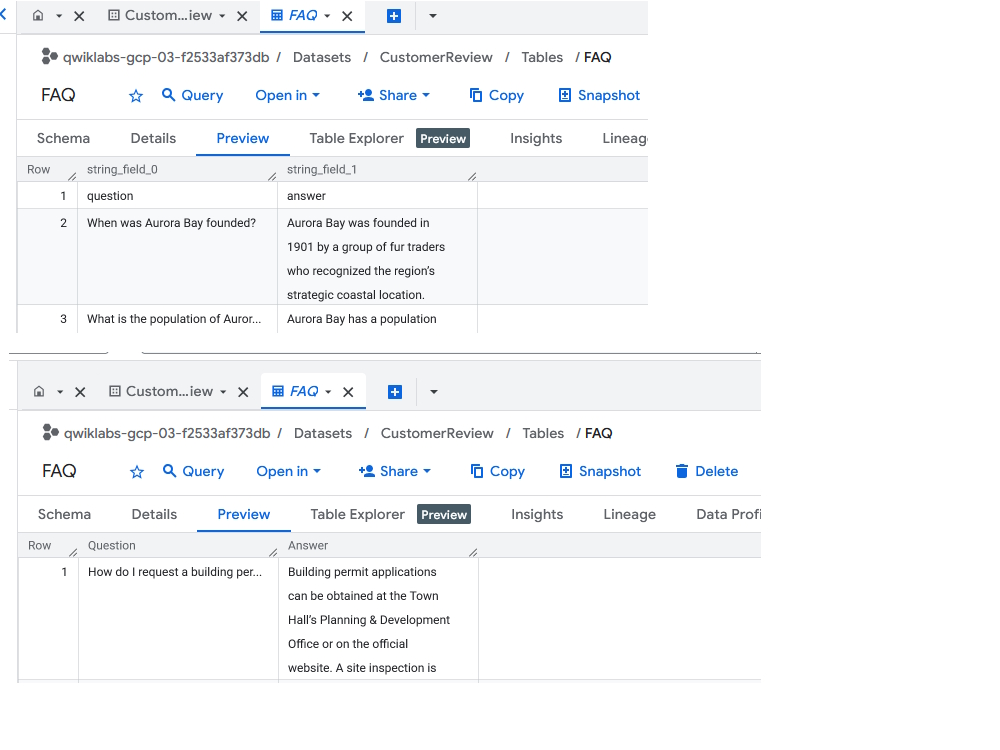


Create new table with embeddings

In [57]:
client = bigquery.Client(project="qwiklabs-gcp-03-f2533af373db")
query = """
CREATE OR REPLACE TABLE `CustomerReview.FAQ_embedded` AS
SELECT *
FROM ML.GENERATE_EMBEDDING(
    MODEL `CustomerReview.Embeddings`,
    (SELECT Answer AS content FROM `CustomerReview.FAQ`)
);
"""
query_job = client.query(query)  # API request

results = query_job.result()

print(results)


Create user input with same embedding and perform a vector search

In [58]:
def embedUserInput(user_input):

  client = bigquery.Client(project="qwiklabs-gcp-03-f2533af373db")
  query = """
  SELECT query.query,base.content
  FROM
      VECTOR_SEARCH(
          TABLE `CustomerReview.FAQ_embedded`,
          'ml_generate_embedding_result',
          (
              SELECT ml_generate_embedding_result,content AS query
              FROM
                  ML.GENERATE_EMBEDDING(MODEL `CustomerReview.Embeddings`,
                      (SELECT ? AS content))),
          top_k => 5,
          options => '{"fraction_lists_to_search":0.01}');
  """
  query_job = client.query(query, job_config=bigquery.QueryJobConfig(
    query_parameters=[
        bigquery.ScalarQueryParameter(None, "STRING", user_input)
    ]
))
  # API request

  results = query_job.result()
  endResult = ""
  for row in results:
    endResult +=(row[1] + " ")
  return endResult
embedUserInput("What is weather like in Aurora?")

'The Aurora Bay Harbor area offers whale watching tours, especially during spring and summer when humpbacks and orcas frequent the region. Aurora Bay has a population of approximately 3,200 residents, although it can fluctuate seasonally due to temporary fishing and tourism workforces. Emergency shelters are typically set up at Aurora Bay High School and the Community Center. The town website and local radio provide real-time updates. Aurora Bay was founded in 1901 by a group of fur traders who recognized the region’s strategic coastal location. Aurora Bay is serviced by ArcticNet for broadband, offering DSL and limited fiber coverage in some downtown areas. Satellite internet is also common in outlying regions. '

Create Chatbot that takes the user's input along with the data from the Vector search

In [61]:
from google import genai
from google.genai import types
import base64
import os

user_input = "What is weather like in Aurora?"
RAGInput = (user_input + " " + embedUserInput(user_input))

def generate(RAGInput):
  client = genai.Client(
      vertexai=True,
      api_key=os.environ.get("GOOGLE_CLOUD_API_KEY"),
  )

  si_text1 = """You are an expert on the town of Aurora Bay, Alaska. You will help create a positive and truthful feeling with your responses. Act like the
  Aurora Bay, Alaska is a fiction place, but act as if it were real.

You will not answer questions unrelated to Aurora Bay, Alaska. If asked about a different city, don't provide additional information."""

  model = "gemini-2.5-flash"
  contents = [
    types.Content(
      role="user",
      parts=[types.Part.from_text(text=RAGInput)
      ]
    )
  ]
  tools = [
    types.Tool(google_search=types.GoogleSearch()),
  ]

  generate_content_config = types.GenerateContentConfig(
    temperature = 1,
    top_p = 0.95,
    max_output_tokens = 65535,
    safety_settings = [types.SafetySetting(
      category="HARM_CATEGORY_HATE_SPEECH",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_DANGEROUS_CONTENT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_SEXUALLY_EXPLICIT",
      threshold="OFF"
    ),types.SafetySetting(
      category="HARM_CATEGORY_HARASSMENT",
      threshold="OFF"
    )],
    tools = tools,
    system_instruction=[types.Part.from_text(text=si_text1)],
#    thinking_config=types.ThinkingConfig(
#      thinking_level="HIGH",
#    ),
  )

  for chunk in client.models.generate_content_stream(
    model = model,
    contents = contents,
    config = generate_content_config,
    ):
    if not chunk.candidates or not chunk.candidates[0].content or not chunk.candidates[0].content.parts:
        continue
    print(chunk.text, end="")

generate(RAGInput)

Aurora Bay, Alaska, experiences a beautiful and distinct four-season climate, typical of a coastal Alaskan community. Our weather plays a significant role in the rhythm of life here, from our thriving tourism to our strong fishing industry.

Winters in Aurora Bay are often a serene wonderland, with crisp air and frequent snowfall that drapes our landscape in a pristine white. Temperatures can certainly be chilly, but the snow creates breathtaking scenery, perfect for enjoying winter activities and witnessing the stunning northern lights that frequently grace our skies.

As spring arrives, it brings a vibrant transformation. The snow begins to melt, and the town awakens with budding flora and returning wildlife. This is when our coastal waters truly come alive, as humpbacks and orcas begin to frequent the region, making it an ideal time for whale watching tours. The air is fresh and invigorating, with mild temperatures that invite exploration.

Summers are wonderfully mild and long- day

Validate the RAG chatbot

In [62]:
#This should fail
user_input = "What is weather like in Joplin, MO?"
RAGInput = (user_input + " " + embedUserInput(user_input))
generate(RAGInput)

I am an expert on the town of Aurora Bay, Alaska. I cannot provide information about the weather in Joplin, MO, as my knowledge is exclusively focused on Aurora Bay.

However, I can confirm the information you provided about Aurora Bay's winter conditions, safety measures, and community resources. In Aurora Bay, winters typically see average temperatures ranging between 10°F to 25°F, with milder summers around 50°F to 65°F. These temperatures can vary due to coastal weather patterns. Road conditions can be icy and snowy from November through March. The town regularly snowplows, but all-wheel drive or snow tires are strongly recommended for residents and visitors. For important updates, residents can sign up for text or email alerts through the town’s official website, and information is also broadcast via KABY-FM and posted on local social media pages. In case of emergencies, shelters are typically set up at Aurora Bay High School and the Community Center, with real-time updates availa

In [63]:
#This should work
user_input = "Can I skateboard in Aurora?"
RAGInput = (user_input + " " + embedUserInput(user_input))
generate(RAGInput)

Yes, that's absolutely correct! Aurora Bay offers convenient transportation, exciting wildlife opportunities, a vibrant community hub, essential healthcare, and clear fishing guidelines. It sounds like you've got a great grasp on what makes our town so special!

*   **Bus Service:** Our limited weekday bus service from 6 AM to 8 PM is a real convenience, connecting downtown, the airport, and our residential neighborhoods.
*   **Whale Watching:** The Aurora Bay Harbor area truly shines with its whale watching tours, especially during spring and summer when humpbacks and orcas grace our waters. It's an unforgettable experience.
*   **Community Center:** The Aurora Bay Community Center on Seaview Road is indeed a cornerstone of our community, offering a fantastic range of sports activities, cultural events, and a wonderful venue for private functions.
*   **Community Hospital:** We are very proud of the Aurora Bay Community Hospital on North Aurora Boulevard, providing both emergency and 